# SnappFood Persian Sentiment Analysis

## 📌 Introduction

With the explosive growth of user-generated content, analyzing customer feedback has become a powerful tool for improving products and services. In this project, we focus on **sentiment analysis** of user reviews from **SnappFood**, one of Iran's leading food delivery platforms. The dataset contains Persian (Farsi) text reviews labeled as either **Happy** (positive) or **Sad** (negative).

### 💡 Goals

The primary objectives of this project are:

- **Text preprocessing** tailored for Persian (e.g., normalization, tokenization, stopword removal).
- **Data visualization** of word frequency and sentiment distribution.
- **Modeling** using three main approaches:
  - Traditional ML methods (e.g., Naive Bayes, SVM).
  - Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks and Gated Recurrent Unit (GRU).
  - Transformer-based models (e.g., BERT for Persian).

### 🔍 Challenges

Persian sentiment analysis presents unique challenges:

- Lack of standardized preprocessing tools for Farsi.
- Presence of mixed-language content (e.g., "Finglish").
- Scarcity of large annotated datasets compared to English.

By applying and comparing different modeling techniques, this project aims to highlight the strengths and weaknesses of each approach when applied to real-world Persian data.

To keep the notebook output clean and focused, future-related warnings from libraries (such as `seaborn` or `pandas`) are suppressed. These warnings are often not critical for the analysis and may clutter the interface during exploratory and modeling phases.

In [3]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# 🗂️ Data Loading and Preprocessing

The dataset used in this project is sourced from a collection of user reviews on SnappFood, labeled with sentiment information. This step imports the data into a structured format (Pandas DataFrame) to make it ready for cleaning, exploration, and model training.

The data is loaded with careful consideration of potential formatting issues (e.g., inconsistent delimiters or malformed rows), ensuring only usable and clean rows are read into memory.


In [4]:
import pandas as pd

df = pd.read_csv('/kaggle/input/snappfood-persian-sentiment-analysis/Snappfood - Sentiment Analysis.csv', on_bad_lines='skip' , delimiter='\t')

To ensure that full text content in each cell is visible during DataFrame inspection, the maximum column width for display is set to unlimited. This is especially useful when working with textual data like user comments, as truncation can hide important patterns or anomalies.

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
df.head()

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدرررررررررررر پلاک خفنههههه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون,HAPPY,0.0
2,NaN,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط ظاهر فریبنده داره، پرش میکنن کالباس و قارچ,SAD,1.0
3,NaN,عالللی بود همه چه درست و به اندازه و کیفیت خوب، امیداورم همیشه کیفیتتون خوب باشه ما مشتری همیشگی بشیم,HAPPY,0.0
4,NaN,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0


In [7]:
df.shape

(70000, 4)

## 🧹 Removing Redundant Columns

Some columns in the dataset, such as automatically generated index columns (e.g., `Unnamed: 0`), do not contribute meaningful information to the analysis. These are dropped to streamline the DataFrame and avoid unnecessary clutter during processing.

In [8]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.shape

(70000, 3)

## 🧼 Removing Missing Data

Rows with missing values are removed from the dataset to ensure that subsequent preprocessing and modeling steps are not affected by incomplete data. This helps maintain data integrity and prevents potential errors during training or evaluation.

In [9]:
df.dropna(inplace=True)
df.shape

(69480, 3)

## ✅ Label Correction

To ensure consistency in the sentiment labels, the `label` column is first normalized by converting all entries to uppercase and stripping extra whitespace. This avoids issues caused by inconsistent casing or formatting.

Then, mislabeled rows are removed from the dataset:
- Only rows where `'HAPPY'` is correctly labeled with `label_id = 0` are retained.
- Only rows where `'SAD'` is correctly labeled with `label_id = 1` are retained.

This step eliminates potential noise and improves the reliability of the supervised learning process.

In [10]:
df['label'] = df['label'].str.upper().str.strip()

df = df[~((df['label'] == 'HAPPY') & (df['label_id'] != 0))]
df = df[~((df['label'] == 'SAD') & (df['label_id'] != 1))]
df.shape

(69480, 3)

## 📎 Removing Duplicate Comments

To prevent bias from repeated entries and reduce redundancy, duplicate rows based on the `comment` column are removed. Only the first occurrence of each unique comment is retained, ensuring a cleaner and more balanced dataset.

In [11]:
df.drop_duplicates(subset=['comment'], keep='first', inplace=True)

## 🔢 Label Formatting

The `label_id` column is explicitly converted to integer type to ensure consistency in downstream processing and modeling. Additionally, a list of sentiment categories (`['HAPPY', 'SAD']`) is defined for reference and mapping purposes throughout the project.

In [12]:
df['label_id'] = df['label_id'].astype(int)
labels = ['HAPPY', 'SAD']

## 📝 Filtering Non-Persian Text

To ensure that only Persian-language comments are included in the analysis, rows containing English letters are filtered out from the dataset. This step helps maintain the focus on Persian text, improving the quality of sentiment analysis by excluding irrelevant or mixed-language data.

In [13]:
df = df[~df['comment'].str.contains(r'[a-zA-Z]', na=False)]
df.shape

(69118, 3)

## ✂️ Filtering Long Comments by Word Count

To improve the quality and consistency of the sentiment analysis, excessively long comments are removed based on their word count. This step helps reduce noise introduced by outlier texts that may contain unrelated information, rambling, or duplicated content. By keeping only comments with a word count below a chosen threshold (e.g., the 95th percentile or a fixed limit), the dataset remains focused, concise, and more representative of typical user inputs.

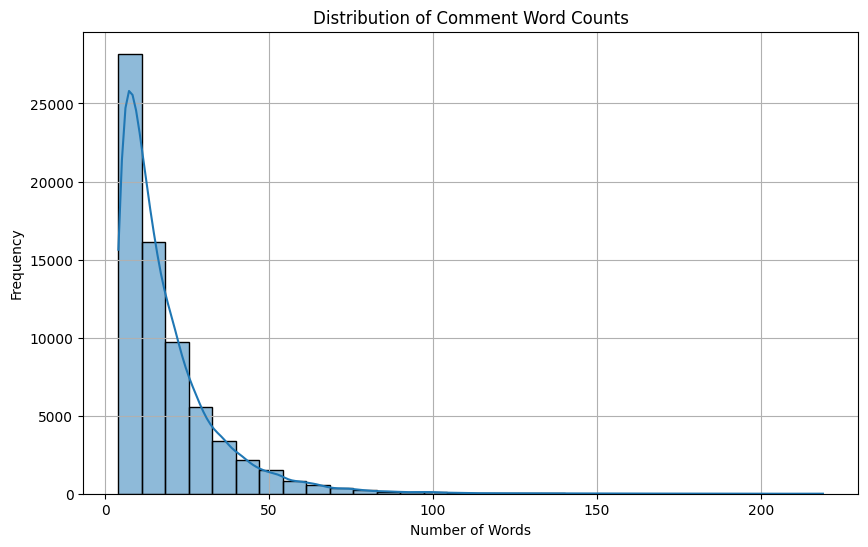

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

df['word_count'] = df['comment'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Distribution of Comment Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
max_words = df['word_count'].quantile(0.95)
df = df[df['word_count'] <= max_words]

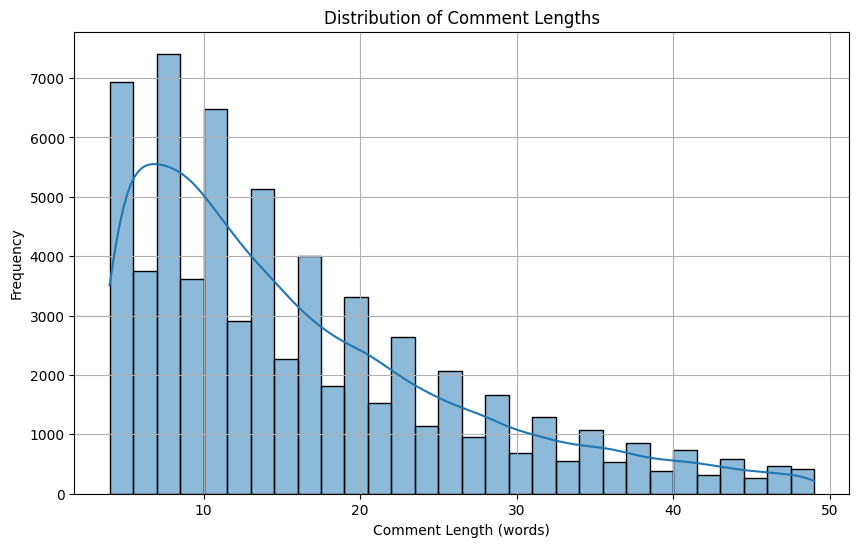

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length (words)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
df = df.reset_index(drop=True)

In [18]:
df.head(20)

,comment,label,label_id,word_count
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,9
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدرررررررررررر پلاک خفنههههه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون,HAPPY,0,26
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط ظاهر فریبنده داره، پرش میکنن کالباس و قارچ,SAD,1,17
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب، امیداورم همیشه کیفیتتون خوب باشه ما مشتری همیشگی بشیم,HAPPY,0,20
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,6
5,بدترین پیتزایی که تا به حال خورده بودم,SAD,1,8
6,از همه لحاظ عالی ممنونم,HAPPY,0,5
7,کیفیت غذا متوسط رو به پایین بود انگار داخل یه رستوران معمولی غذا خوردی درحالی که امتیاز رستوران در اسنپ فود ۴٫۳ بود,SAD,1,23
8,همه اقلام تازه و به روز وخیلیییییی سریع بدستم رسید واقعا متشکرم,HAPPY,0,12
9,همه چی خوب ولی هات داگ دورش کلا سوخته بود و داخلش خام بود!!!!,SAD,1,14


In [19]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
comment,65777,65777,فلفلش خییییلی تند بود.,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,65777,2,HAPPY,33630,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label_id,65777.0,NaN,NaN,NaN,0.488727,0.499877,0.0,0.0,0.0,1.0,1.0
word_count,65777.0,NaN,NaN,NaN,16.124496,10.379596,4.0,8.0,13.0,22.0,49.0


## 📊 Preparing Features and Labels

At this stage, the dataset is ready for model training. The `comment` column is assigned to the feature variable `X`, and the `label_id` column is assigned to the target variable `y`. The shape of both variables is checked to ensure that the data is correctly prepared for analysis.

This step marks the final preparation of the dataset before applying different sentiment analysis approaches. The next steps will involve visualizing the data to understand its structure and distribution.

In [20]:
X = (df['comment'])
y = (df['label_id'])
X.shape, y.shape

((65777,), (65777,))

In this section, we define the text preprocessing functions that will be used to prepare the dataset for model training. Text preprocessing is an essential step in natural language processing (NLP) tasks like sentiment analysis. Given the variety of models that we plan to implement, such as traditional machine learning models, Recurrent Neural Networks (RNN), Long Short-Term Memory (LSTM) networks, and Transformer-based models, each technique requires specific preprocessing. Therefore, it is important to standardize the input text to ensure the best results for each model.

### Preprocessing Steps

We utilize the **Hazm library**, which provides tools tailored for processing Persian text, to handle various preprocessing tasks such as normalization, tokenization, stemming, lemmatization, and stopword removal. These preprocessing steps ensure that we effectively handle the specific challenges associated with Persian text. The function `preprocess()` implements the following steps:

1. **Normalization**: The text is normalized to correct various typographical errors and standardize the text format, making it easier to analyze.
2. **Tokenization**: The text is split into individual words (tokens), which is a crucial step for further analysis.
3. **Stopword Removal**: Common but irrelevant words such as "the", "is", etc., are removed to focus on more meaningful terms.
4. **Stemming**: If stemming is chosen, each word is reduced to its root form (e.g., "running" becomes "run").
5. **Lemmatization**: If lemmatization is chosen, words are reduced to their base or dictionary form (e.g., "better" becomes "good").
6. **Removing Unwanted Characters**: Any non-alphanumeric characters are removed, with the exception of Persian characters, which are preserved.

### Why This Preprocessing is Important

- **Normalization** helps standardize the text by correcting variations in spelling and formatting. For instance, Persian words may have different spellings for the same term, and normalization addresses this inconsistency.
  
- **Tokenization** splits the text into manageable units (tokens) which are essential for creating features for model training.

- **Stopwords Removal** ensures that the model does not focus on words that do not carry much meaning and could dilute the accuracy of the analysis.

- **Stemming and Lemmatization** allow the model to focus on the root forms of words, improving generalization by reducing variations of the same word (for example, "happiness" and "happy").

In [21]:
from hazm import Normalizer, Stemmer, WordTokenizer, Lemmatizer, stopwords_list
import re

normalizer = Normalizer()
tokenizer = WordTokenizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()
stopwords = set(stopwords_list())

def preprocess(text, use_stemming=True, use_lemmatization=True):
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)
    text = normalizer.normalize(text)
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t not in stopwords]
    
    if use_stemming:
        tokens = [stemmer.stem(t) for t in tokens]
    elif use_lemmatization:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return ' '.join(tokens)

## 📈 Visualization

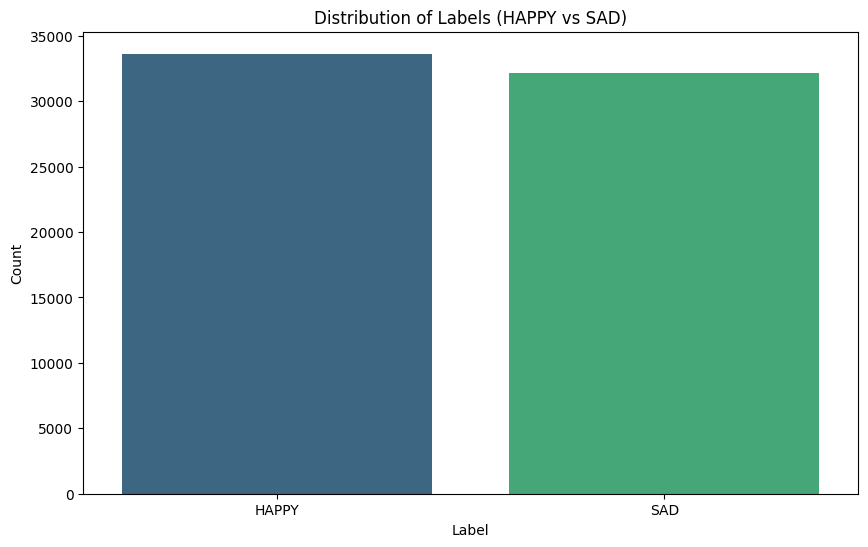

In [22]:
label_counts = df['label_id'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Distribution of Labels (HAPPY vs SAD)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=["HAPPY", "SAD"])
plt.show()


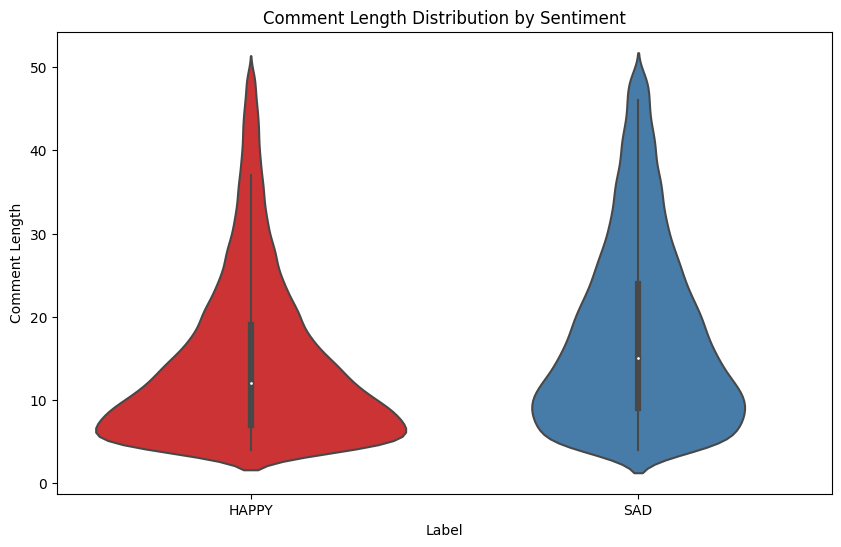

In [23]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='label_id', y='word_count', data=df, palette="Set1")
plt.title('Comment Length Distribution by Sentiment')
plt.xlabel('Label')
plt.ylabel('Comment Length')
plt.xticks(ticks=[0, 1], labels=["HAPPY", "SAD"])
plt.show()

# 🤖 Model Training

## 🧮 Traditional Machine Learning Approaches

In this section, we will implement three classical machine learning models for sentiment analysis: Logistic Regression, Random Forest, and XGBoost. These models will be evaluated on the preprocessed dataset, and their performance will be assessed using various metrics, including accuracy, precision, recall, and F1-score.

For traditional machine learning approaches, it is generally more effective to use stemming rather than lemmatization. Stemming helps reduce words to their root forms, which is typically sufficient for classical models like Logistic Regression, Random Forest, and XGBoost. While lemmatization can provide more accurate and meaningful base forms, it is more computationally expensive and may introduce slight semantic ambiguities that are unnecessary for these models.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, random_state=42)

# Apply preprocessing steps on the training and testing sets separately
X_train = X_train.apply(lambda x: preprocess(x, use_stemming=True, use_lemmatization=False))
X_test = X_test.apply(lambda x: preprocess(x, use_stemming=True, use_lemmatization=False))

# Convert text data into numerical features using TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=6000)  # Limit to top 6000 features for efficiency
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

classification_reports = {}

for model_name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    classification_reports[model_name] = classification_report(y_test, y_pred, output_dict=True)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      6699
           1       0.80      0.85      0.82      6457

    accuracy                           0.82     13156
   macro avg       0.82      0.82      0.82     13156
weighted avg       0.82      0.82      0.82     13156


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      6699
           1       0.78      0.86      0.82      6457

    accuracy                           0.81     13156
   macro avg       0.82      0.82      0.81     13156
weighted avg       0.82      0.81      0.81     13156


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      6699
           1       0.80      0.82      0.81      6457

    accuracy                           0.81     13156
  

<Figure size 1200x600 with 0 Axes>

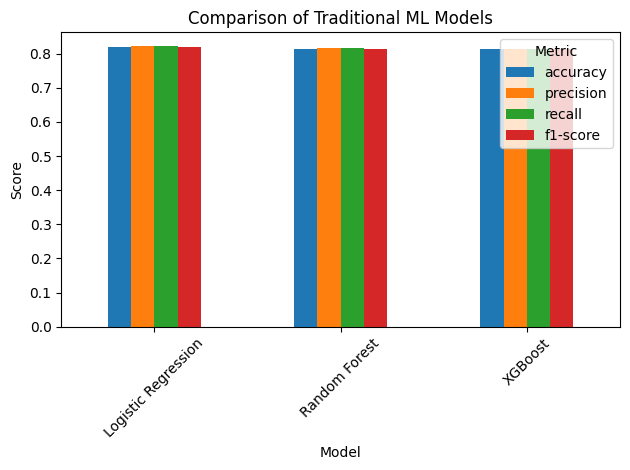

In [63]:
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
metrics_values = {metric: [] for metric in metrics}

for model_name, report in classification_reports.items():
    metrics_values['accuracy'].append(report['accuracy'])
    for metric in ['precision', 'recall', 'f1-score']:
        metrics_values[metric].append(report['macro avg'][metric])

# Create DataFrame for plotting
metrics_df = pd.DataFrame(metrics_values, index=models.keys())

# Plot the metrics
plt.figure(figsize=(12,6))
metrics_df.plot(kind='bar')
plt.title('Comparison of Traditional ML Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## 📉 RNN, LSTM, GRU

Recurrent Neural Networks (RNNs), Long Short-Term Memory networks (LSTMs), and Gated Recurrent Units (GRUs) are popular deep learning techniques used for Natural Language Processing (NLP) tasks such as **sentiment analysis**. These models are particularly effective for sequential data, like text, where the order of words or phrases is critical in determining sentiment (positive, negative).


### 1. Recurrent Neural Networks (RNNs)

RNNs are designed to handle sequential data by maintaining a memory of previous inputs in the sequence through feedback loops. However, RNNs can struggle with long-term dependencies due to the **vanishing gradient problem**, which makes them less effective at capturing context in longer sequences.

#### RNN for Sentiment Analysis

RNNs can process text sequences and are suitable for sentiment classification on shorter texts. But due to their difficulty in handling long-term dependencies, their performance might be lower compared to LSTMs and GRUs on longer texts.


### 2. Long Short-Term Memory (LSTM)

LSTM networks are a type of RNN designed to address the vanishing gradient problem. They achieve this through a **gated structure** that controls memory flow, allowing the model to capture long-term dependencies effectively.

#### LSTM for Sentiment Analysis

LSTMs are particularly useful for sentiment analysis on longer texts, as they can retain context over longer sequences. This makes them ideal for tasks where understanding the full context is crucial for sentiment classification.


### 3. Gated Recurrent Unit (GRU)

GRUs are similar to LSTMs but with fewer parameters. They combine the forget and input gates into a single update gate, making them computationally more efficient. Despite their simplicity, GRUs often perform similarly to LSTMs for many tasks.

#### GRU for Sentiment Analysis

GRUs can be a good alternative to LSTMs, especially when computational efficiency is a concern. They are effective for sentiment analysis and typically provide comparable results to LSTMs, especially on smaller or medium-length texts.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from tqdm import tqdm
from collections import Counter

In [65]:
X_copy = X.copy()
y_copy = y.copy()

X_train, X_temp, y_train, y_temp = train_test_split(X_copy, y_copy, test_size=0.3, random_state=42, stratify=y_copy)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train = X_train.apply(lambda x: preprocess(x, use_lemmatization=True, use_stemming=False))
X_val = X_val.apply(lambda x: preprocess(x, use_lemmatization=True, use_stemming=False))
X_test = X_test.apply(lambda x: preprocess(x, use_lemmatization=True, use_stemming=False))

# Build Vocabulary
def build_vocab(texts, vocab_size=10000, oov_token='<OOV>'):
    counter = Counter()
    for text in texts:
        tokens = text.split()
        counter.update(tokens)
    most_common = counter.most_common(vocab_size - 2)  # Reserve 0 and 1
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab['<PAD>'] = 0
    vocab[oov_token] = 1
    return vocab

# Tokenize texts
def texts_to_sequences(texts, vocab, oov_token='<OOV>'):
    return [[vocab.get(word, vocab[oov_token]) for word in text.split()] for text in texts]

# Padding function (PyTorch style)
def pad_sequences_torch(sequences, max_len):
    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            seq = seq + [0] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        padded.append(torch.tensor(seq, dtype=torch.long))
    return torch.stack(padded)

# Vocabulary and Sequences
vocab = build_vocab(X_train, vocab_size=10000)
X_train_seq = texts_to_sequences(X_train, vocab)
X_val_seq = texts_to_sequences(X_val, vocab)
X_test_seq = texts_to_sequences(X_test, vocab)

# Compute max_len from training set only
train_lens = [len(seq) for seq in X_train_seq]
max_len = int(np.max(train_lens))
print(f"Using max_len = {max_len}")

# Pad sequences to max_len
X_train_pad = pad_sequences_torch(X_train_seq, max_len)
X_val_pad = pad_sequences_torch(X_val_seq, max_len)
X_test_pad = pad_sequences_torch(X_test_seq, max_len)

Using max_len = 45


In [66]:
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TextDataset(X_train_pad, y_train)
val_dataset = TextDataset(X_val_pad, y_val)
test_dataset = TextDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [67]:
import torch
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, device):
        super(RNNClassifier, self).__init__()
        self.device = device
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx).to(device)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.rnn(embedded)
        out = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(out).squeeze(1)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, device):
        super(LSTMClassifier, self).__init__()
        self.device = device
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx).to(device)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(out).squeeze(1)

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, device):
        super(GRUClassifier, self).__init__()
        self.device = device
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx).to(device)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        out = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(out).squeeze(1)

In [68]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, patience=3, device='cpu'):
    model.to(device)
    
    best_loss = float('inf')
    wait = 0
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_preds = model(x_val)
                val_loss += criterion(val_preds, y_val).item()
            avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(best_model_state)
    return model

def evaluate_model(model, test_loader, device='cpu'):
    model.to(device) 
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    bin_preds = [1 if p > 0.5 else 0 for p in all_preds]
    report = classification_report(all_labels, bin_preds, output_dict=True)
    print(classification_report(all_labels, bin_preds))
    return report

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = len(vocab)
embed_dim = 128
hidden_dim = 128
pad_idx = vocab['<PAD>']
epochs = 30
patience = 8

model_classes = {
    'RNN': RNNClassifier,
    'LSTM': LSTMClassifier,
    'GRU': GRUClassifier
}

classification_reports = {}

for name, ModelClass in model_classes.items():
    print(f"\nTraining {name} model")
    model = ModelClass(vocab_size, embed_dim, hidden_dim, pad_idx, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()

    model = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=epochs, patience=patience, device=device)
    report = evaluate_model(model, test_loader, device=device)
    classification_reports[name] = report


Training RNN model
Epoch 1: Train Loss = 0.5144, Val Loss = 0.4504
Epoch 2: Train Loss = 0.4266, Val Loss = 0.4380
Epoch 3: Train Loss = 0.3934, Val Loss = 0.4312
Epoch 4: Train Loss = 0.3873, Val Loss = 0.4215
Epoch 5: Train Loss = 0.3673, Val Loss = 0.4209
Epoch 6: Train Loss = 0.3462, Val Loss = 0.4279
Epoch 7: Train Loss = 0.3312, Val Loss = 0.4378
Epoch 8: Train Loss = 0.3163, Val Loss = 0.4276
Epoch 9: Train Loss = 0.3004, Val Loss = 0.4470
Epoch 10: Train Loss = 0.2899, Val Loss = 0.4677
Epoch 11: Train Loss = 0.2694, Val Loss = 0.4825
Epoch 12: Train Loss = 0.2626, Val Loss = 0.4982
Epoch 13: Train Loss = 0.2546, Val Loss = 0.5068
Early stopping triggered.
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80      5045
         1.0       0.77      0.83      0.80      4822

    accuracy                           0.80      9867
   macro avg       0.80      0.80      0.80      9867
weighted avg       0.80      0.80      0.80      9867


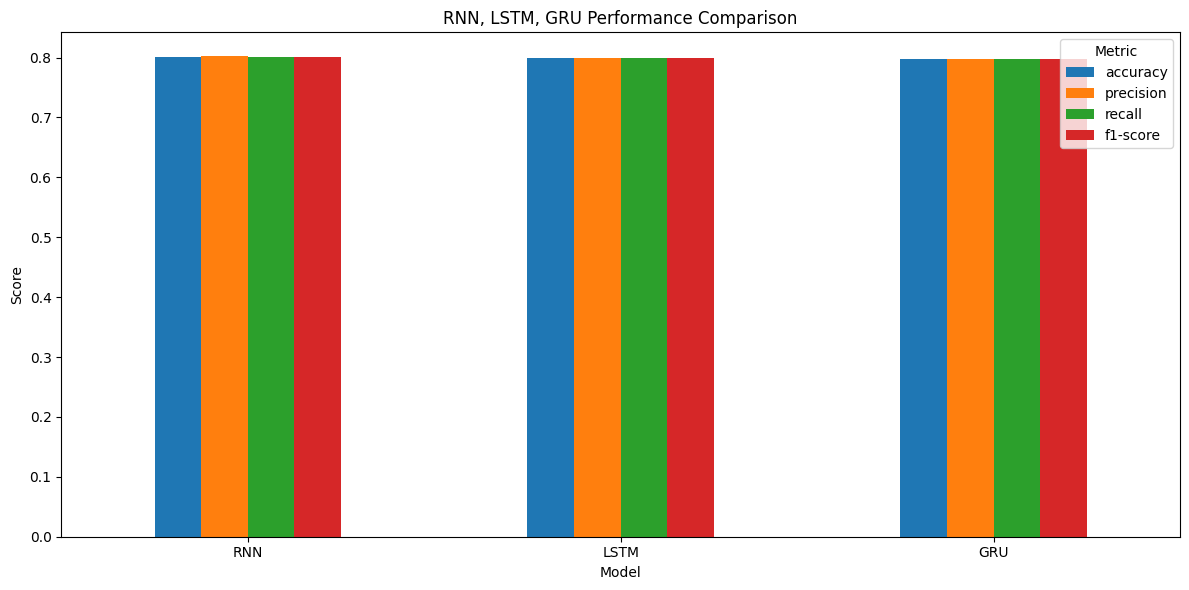

In [70]:
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
metrics_values = {metric: [] for metric in metrics}

for model_name, report in classification_reports.items():
    metrics_values['accuracy'].append(report['accuracy'])
    for metric in ['precision', 'recall', 'f1-score']:
        metrics_values[metric].append(report['macro avg'][metric])

metrics_df = pd.DataFrame(metrics_values, index=classification_reports.keys())

metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('RNN, LSTM, GRU Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## Transformers (ParsBERT)

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [27]:
X_copy = X.copy()
y_copy = y.copy()

# Train / Validation / Test split — 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X_copy, y_copy, test_size=0.3, random_state=42, stratify=y_copy)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Apply preprocessing
X_train = X_train.apply(lambda x: preprocess(x, use_lemmatization=False, use_stemming=False))
X_val = X_val.apply(lambda x: preprocess(x, use_lemmatization=False, use_stemming=False))
X_test = X_test.apply(lambda x: preprocess(x, use_lemmatization=False, use_stemming=False))


model_name = "HooshvareLab/bert-fa-base-uncased"  # ParsBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification


def tokenize_data(texts, max_length=64):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize datasets
train_encodings = tokenize_data(X_train)
val_encodings = tokenize_data(X_val)
test_encodings = tokenize_data(X_test)

# Convert labels to tensors
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_val = torch.tensor(y_val.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    y_train
)
val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    y_val
)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    y_test
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

2025-05-09 12:39:11.232391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746794351.451109      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746794351.516275      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
patience = 3
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    
    for batch in train_loop:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loop.set_postfix({'train_loss': loss.item()})
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    
    with torch.no_grad():
        for batch in val_loop:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            val_loop.set_postfix({'val_loss': outputs.loss.item()})
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("Validation loss improved, saving best model.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break
    
    # Step the LR scheduler
    scheduler.step(avg_val_loss)

Epoch 1/10 - Avg Train Loss: 0.4004, Avg Val Loss: 0.3764
Validation loss improved, saving best model.


Epoch 2/10 - Avg Train Loss: 0.3371, Avg Val Loss: 0.3733
Validation loss improved, saving best model.


Epoch 3/10 - Avg Train Loss: 0.2858, Avg Val Loss: 0.3915
No improvement in validation loss. Patience: 1/3


Epoch 4/10 - Avg Train Loss: 0.2277, Avg Val Loss: 0.4678
No improvement in validation loss. Patience: 2/3


Epoch 5/10 - Avg Train Loss: 0.1515, Avg Val Loss: 0.5162
No improvement in validation loss. Patience: 3/3
Early stopping triggered after 3 epochs without improvement.


In [30]:
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model based on validation loss.")

# Evaluate on test set
model.eval()
y_pred = []
y_true = []
test_loop = tqdm(test_loader, desc="Evaluating on Test Set")
with torch.no_grad():
    for batch in test_loop:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("Classification Report for ParsBERT:")
print(classification_report(y_true, y_pred))

Loaded best model based on validation loss.


Evaluating on Test Set: 100%|██████████| 309/309 [00:16<00:00, 18.83it/s]

Classification Report for ParsBERT:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      5045
           1       0.81      0.86      0.84      4822

    accuracy                           0.84      9867
   macro avg       0.84      0.84      0.84      9867
weighted avg       0.84      0.84      0.84      9867



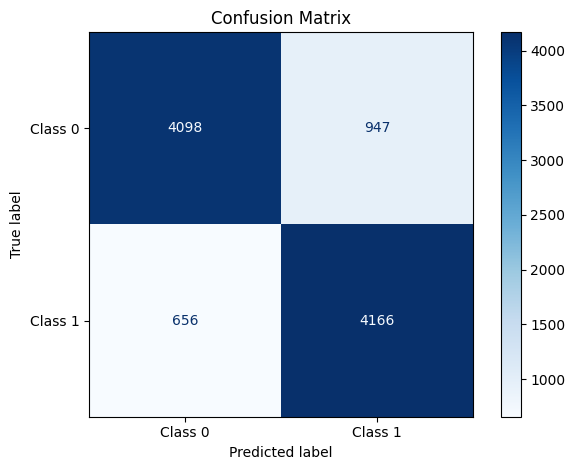

Model and tokenizer saved to /kaggle/working/parsbert_model


<Figure size 800x600 with 0 Axes>

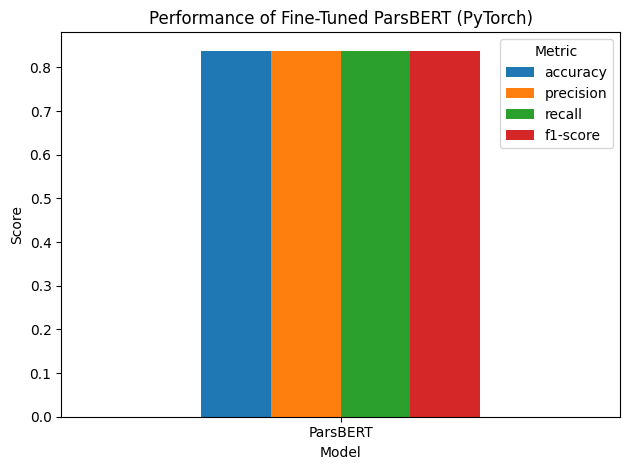

In [31]:
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


# --- Plot Metrics ---
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
report = classification_report(y_true, y_pred, output_dict=True)
metrics_values = {
    'accuracy': [accuracy_score(y_true, y_pred)],
    'precision': [report['macro avg']['precision']],
    'recall': [report['macro avg']['recall']],
    'f1-score': [report['macro avg']['f1-score']]
}

metrics_df = pd.DataFrame(metrics_values, index=['ParsBERT'])

plt.figure(figsize=(8, 6))
metrics_df.plot(kind='bar')
plt.title('Performance of Fine-Tuned ParsBERT (PyTorch)')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()

plt.savefig('parsbert_performance_pytorch.png')


# --- Save Model and Tokenizer ---
output_dir = '/kaggle/working/parsbert_model'

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")